# Tracking growth of shoots across time series in a fully automated pipeline for high throughput phenotyping

In this notebook we will demonstrate the steps of the pipeline used to extract the individual shoots and track their growth across an image time series.
Bellow is a summary of the steps:

1. Load the image time series and reduce resolution (in order to make processing faster)
1. Segment shoots from images (semantic segmentation with DL)
    1. Post-process the segmented shoots to ensure they are mostly continuous (dilution/opening/skeletonisation)
1. Identify pot rim (circle Hough Transform)
1. Shoot identification
    1. Identify shoots belonging to a pot
    1. Identify individual within a pot (within a sector)
1. Tracking development (area of shoot relative to sector)

In [39]:
from utils.image_utils import load_image_ts, reduce_resolution, white_balance
from utils.skeleton_utils import get_endpoints
import cv2
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models_pytorch as smp
import torch
from PIL import Image
from utils.dl.niab import IMG_TRANSFORMS
from skimage.morphology import skeletonize
from scipy.ndimage import label, generate_binary_structure
from utils.dl.model import MCDUNet

ImportError: cannot import name 'hit_or_miss' from 'skimage.morphology' (/home/users/ashine/miniconda3/envs/niab/lib/python3.12/site-packages/skimage/morphology/__init__.py)

## Step 1: Load and pre-process images

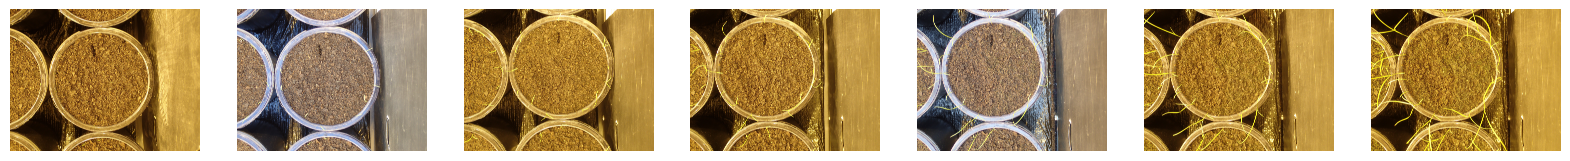

In [2]:
# TODO: Handle edge case of blocks 2 (missing), 3, 4 (TIF, JPG)
# Load image time series and display
raw_images = load_image_ts(dataset_root = "../datasets/niab",
                       exp = 1,
                       block = 1,
                       pot = 31)

fig, ax = plt.subplots(1, len(raw_images), figsize=(20, 20))
for i, image in enumerate(raw_images):
    ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i].axis('off')

In [3]:
# Reduce resolution of images to 10% of the original size to speed up 
# processing (notably segmentation and circle detection)
small_images = [reduce_resolution(image, 10) for image in raw_images]

print("Original image size: ", raw_images[0].shape)
print("Reduced image size: ", small_images[0].shape)

Original image size:  (3456, 4608, 3)
Reduced image size:  (345, 460, 3)


## Step 2: Shoot segmentation

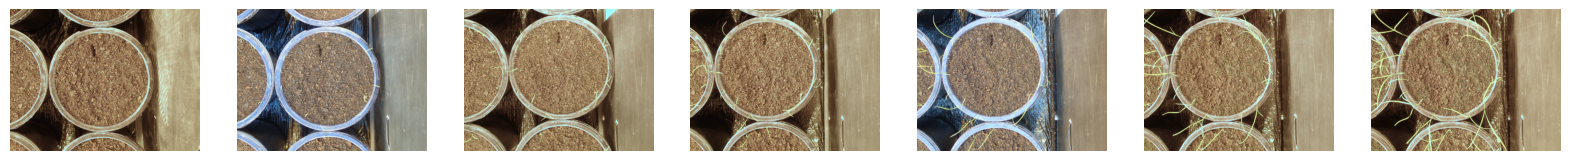

In [4]:
# White balance images to make them more similar across the time series and 
# display
wb_small_images = [white_balance(image) for image in small_images]

fig, ax = plt.subplots(1, len(wb_small_images), figsize=(20, 20))
for i, image in enumerate(wb_small_images):
    ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i].axis('off')

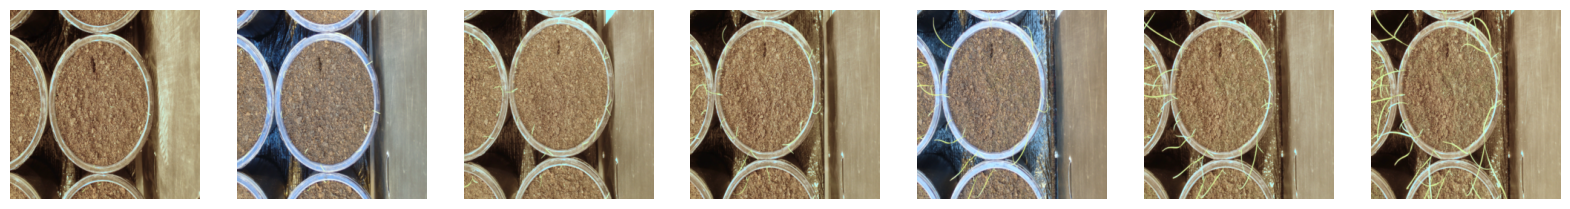

In [5]:
# Transform images for input to the shoot segmentation model
transformed_wb_small_images = [IMG_TRANSFORMS(Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))) for image in wb_small_images]

# display the transformed images
fig, ax = plt.subplots(1, len(transformed_wb_small_images), figsize=(20, 20))
for i, image in enumerate(transformed_wb_small_images):
    ax[i].imshow(image.permute(1, 2, 0))
    ax[i].axis('off')

Running model using cuda device


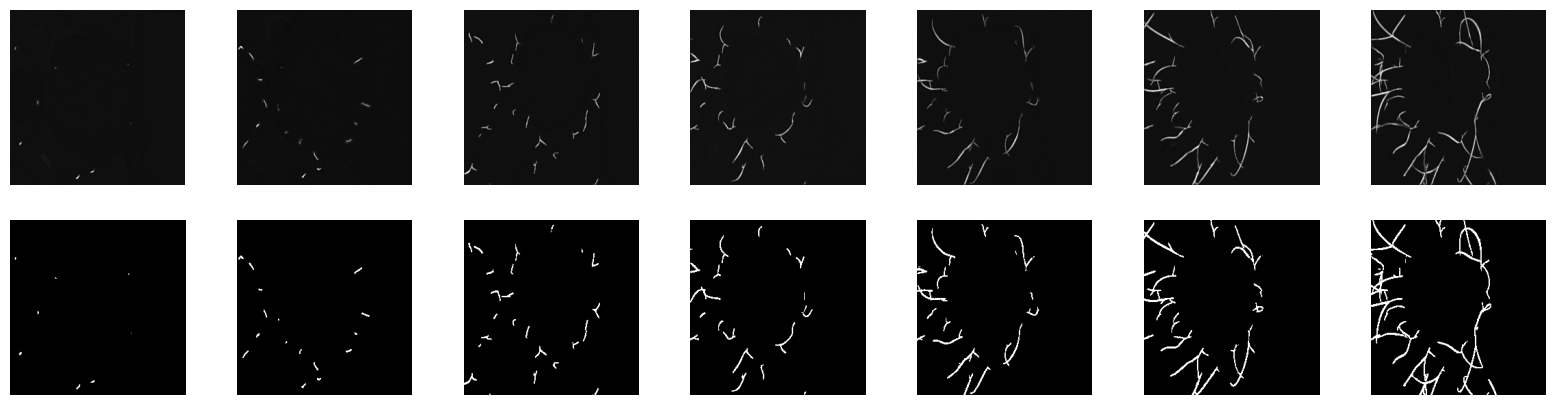

In [6]:
MODEL_PATH = "../models/20240517133228/best_model.pth"
THRESHOLD = 0.7

device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Running model using {device} device")

# Create an instance of the model and move it to the device (GPU or CPU) and load the model parameters
unet_dims = []
for i in range(5):
    unet_dims.append(2**(5 + i))

# # Create an instance of the model and move it to the device (GPU or CPU)
model = MCDUNet(n_channels=3,
             n_classes=1,
             bilinear=True,
             ddims=unet_dims,
             UQ=True,
             ).to(device)

# model = smp.Unet(
#     encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#     classes=1,                      # model output channels (number of classes in your dataset)
# ).to(device)

model.load_state_dict(torch.load(MODEL_PATH))
model.eval()  # Set model to evaluation mode i.e. doesn't change weights

# Inference on the transformed images
predictions = [model(image.unsqueeze(0).to(device)) for image in transformed_wb_small_images]

# Generate binary predictions from the model output
binary_predictions = [prediction.squeeze(0).squeeze(0) > THRESHOLD for prediction in predictions]

# Display predictions and binary predictions
fig, ax = plt.subplots(2, len(predictions), figsize=(20, 5))
for i, (prediction, binary_prediction) in enumerate(zip(predictions, binary_predictions)):
    ax[0, i].imshow(prediction.squeeze(0).squeeze(0).cpu().detach().numpy(), cmap='gray')
    ax[0, i].axis('off')
    ax[1, i].imshow(binary_prediction.cpu().detach().numpy(), cmap='gray')
    ax[1, i].axis('off')

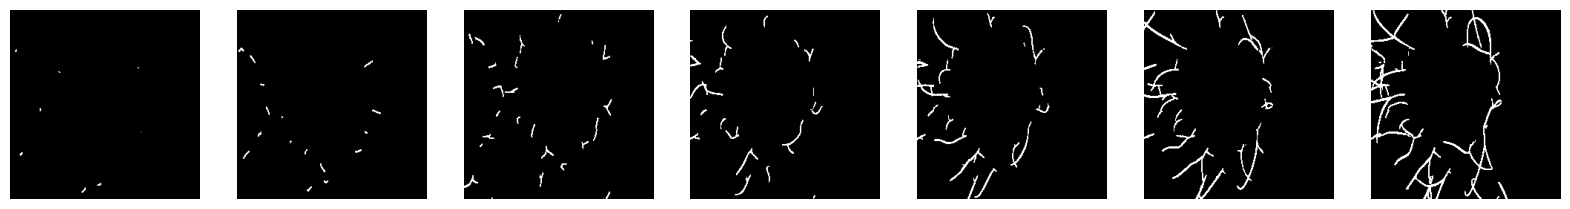

In [7]:
# Increase continuity of the binary predictions by opening (an erosion 
# operation followed by a dilation operation) 
kernel = np.ones((1,1),np.uint8)  # 1x1 kernel does nothing
opened_resized_predictions = [cv2.morphologyEx(prediction.cpu().numpy().astype(np.uint8), cv2.MORPH_OPEN, kernel) for prediction in binary_predictions]

fig, ax = plt.subplots(1, len(small_images), figsize=(20, 5))
for i, image in enumerate(small_images):
    ax[i].imshow(opened_resized_predictions[i], cmap='gray')
    ax[i].axis('off')

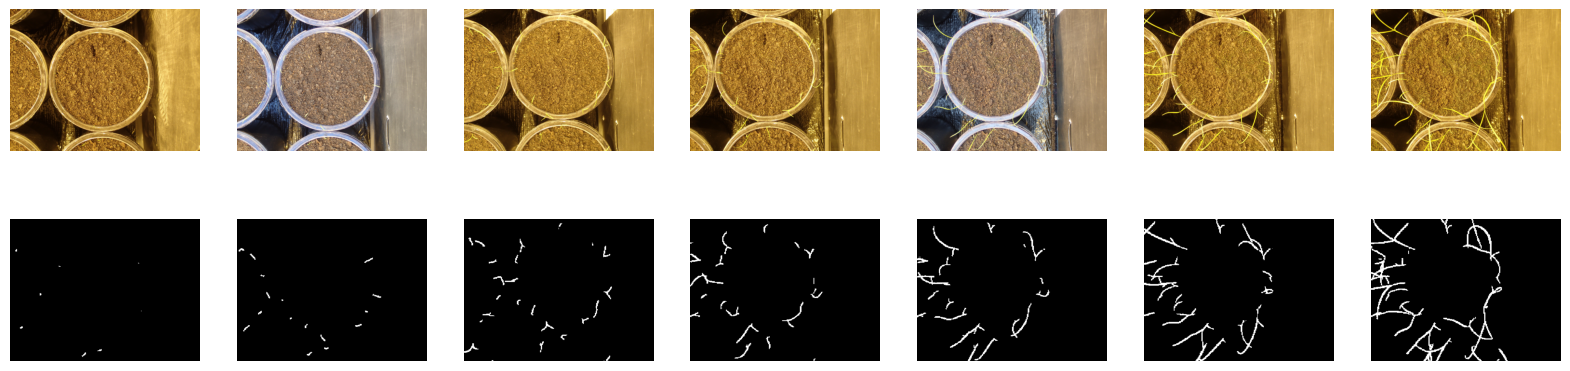

In [8]:
# Resize the predictions so that they match with the small images
resized_predictions = [cv2.resize(prediction, (small_images[0].shape[1], small_images[0].shape[0]), interpolation=cv2.INTER_NEAREST) for prediction in opened_resized_predictions]

# plot the images (row 1 ) and the predictions (row 2)
fig, ax = plt.subplots(2, len(small_images), figsize=(20, 5))
for i, image in enumerate(small_images):
    ax[0, i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[0, i].axis('off')
    ax[1, i].imshow(resized_predictions[i], cmap='gray')
    ax[1, i].axis('off')

## Step 3: Identifying pot rims

[((222, 172), 127), ((220, 170), 127), ((240, 144), 122), ((186, 144), 129), ((184, 148), 126), ((190, 140), 123), ((188, 144), 126)]


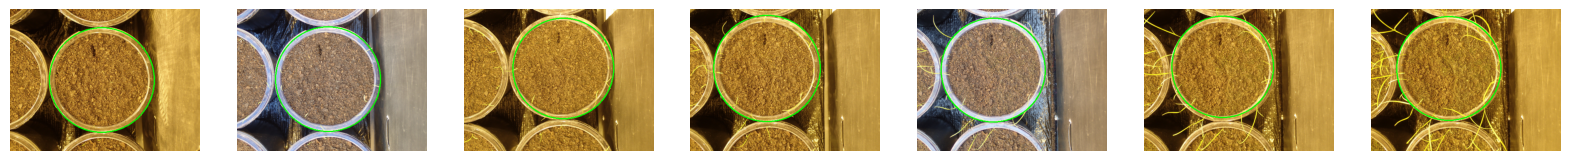

In [9]:
# Convert the images to greyscale for circle detection
grey_small_images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in small_images]

saved_circles = []  # [((x, y), r)...]

# Detect circles in each greyscale image
for i, img in enumerate(grey_small_images):
    # Use HoughCircles to detect circles in the image
    # Parameters have been tuned to detect the pot rim in the images (might need to be adjusted for other images)
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 100, param1=50, param2=30, minRadius=120, maxRadius=135)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for circle in circles[0, :]:
            center = (circle[0], circle[1])
            radius = circle[2]
            saved_circles.append((center, radius))
            cv2.circle(small_images[i], center, radius, (0, 255, 0), 2)

print(saved_circles)

fig, ax = plt.subplots(1, len(small_images), figsize=(20, 20))
for i, image in enumerate(small_images):
    ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i].axis('off')

## Step 4: Shoot identification

### Step 4 (a): Identify shoots belonging to pot

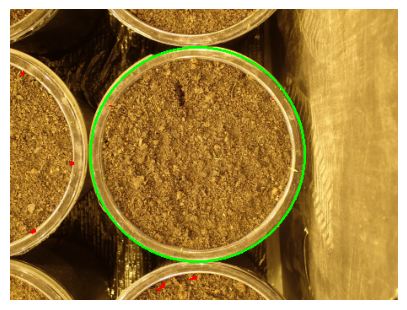

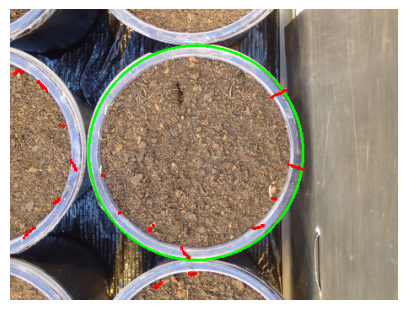

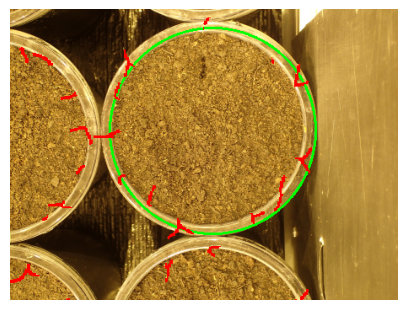

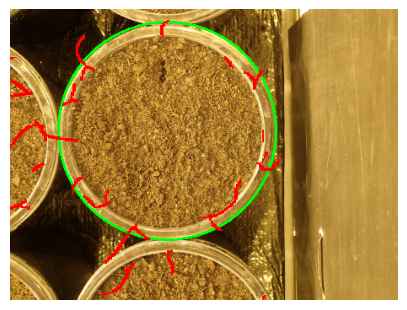

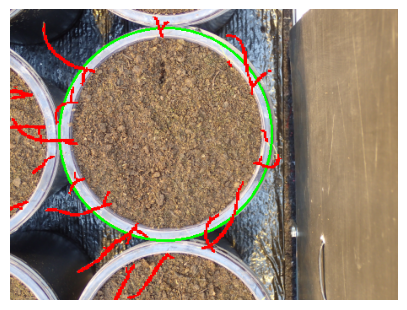

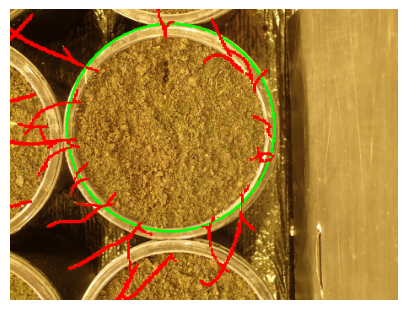

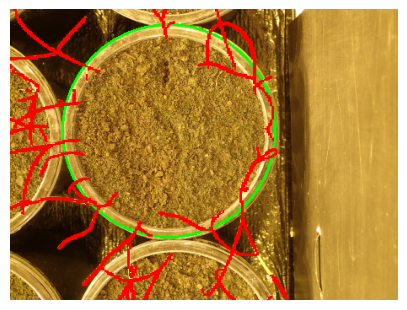

In [10]:
# Overlay the circle on the predictions
for i, (img, prediction) in enumerate(zip(small_images, resized_predictions)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img[prediction == 1] = [255, 0, 0]

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(img)
    ax.axis('off')

    plt.show()

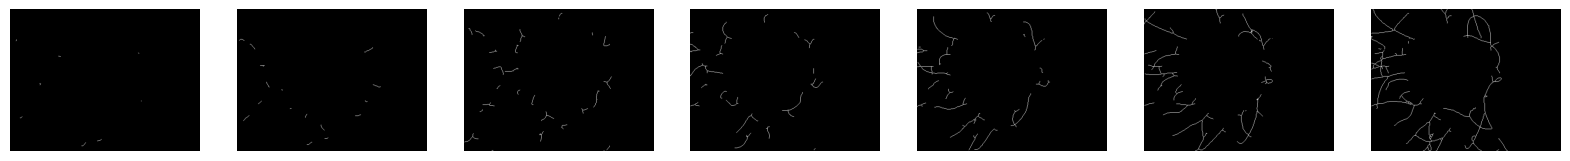

In [11]:
# Skeletonize the binary predictions masks to run logic on the geometry of the shoots and the pot rim
skeletonised_masks = [skeletonize(prediction) for prediction in resized_predictions]

# plot the skeletonised mask
fig, ax = plt.subplots(1, len(skeletonised_masks), figsize=(20, 20))
for i, skeleton in enumerate(skeletonised_masks):
    ax[i].imshow(skeleton, cmap='gray')
    ax[i].axis('off')

Number of labels: 8
Number of labels post filtering: 3
Number of labels: 16
Number of labels post filtering: 8
Number of labels: 26
Number of labels post filtering: 11
Number of labels: 19
Number of labels post filtering: 12
Number of labels: 19
Number of labels post filtering: 12
Number of labels: 14
Number of labels post filtering: 11
Number of labels: 13
Number of labels post filtering: 8


[]

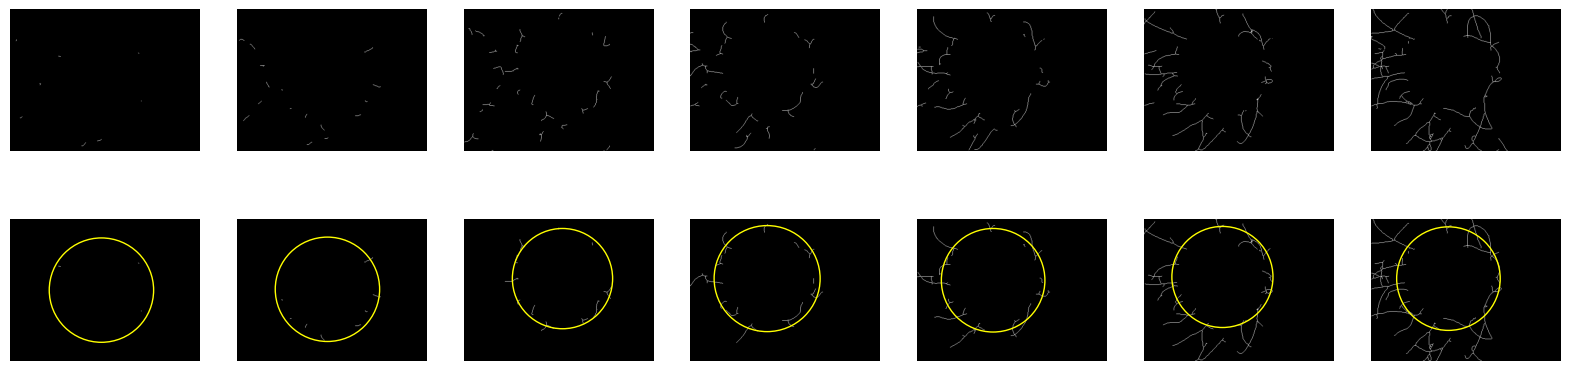

In [12]:
# Initial filtering: removing shoots that do not have an endpoint within the 
# pot rim i.e. that are not from that pot

# Array of filtered masks
filtered_masks = []

# Create a structuring element for 8-connectivity
s = generate_binary_structure(2,2)

for skeletonised_mask_nb in range(len(skeletonised_masks)):

    # Get the coordinates of the circle for the current image
    circle_coords = saved_circles[skeletonised_mask_nb]  # ((x, y), r)

    # Label function separates each skeleton in the skeletonised mask based on 
    # connectivity. Uses 4-connectivity by default, so we use a structuring 
    # element to specify 8-connectivity.
    # TODO: This is a bit naive as if shoots in the pot overlap with shoots not
    # from the pot, they are still connected and hence will be kept.
    labeled_skeletons, num_labels = label(skeletonised_masks[skeletonised_mask_nb], structure=s)

    print(f"Number of labels: {num_labels}")

    # New image of the same shape as original
    new_image = np.zeros_like(skeletonised_masks[skeletonised_mask_nb]).astype(np.uint8)

    # For each individual skeleton (continuous shape) in the image
    for skeleton in range(1, num_labels + 1):

        # Highlight the particular skeleton
        highlighted = np.where(labeled_skeletons == skeleton, 1, 0)

        # Get skeleton endpoints
        end_points = get_endpoints(highlighted)

        # If at least 1 endpoint is within the circle, assume that the shoot is
        # part of the pot
        is_in_circle = False
        for point in end_points:
            in_circle = ((point[0] - circle_coords[0][1])**2 + (point[1] - circle_coords[0][0])**2) <= circle_coords[1]**2
            if in_circle:
                is_in_circle = True
                break

        # If the skeleton meets the condition (is_in_circle), add it to the 
        # skeletons to form the newly filtered image
        if is_in_circle:
            new_image += highlighted.astype(np.uint8)

    # Nb of labels post filtering
    labeled_skeletons, num_labels = label(new_image, structure=s)
    print(f"Number of labels post filtering: {num_labels}")

    # Save the new image post-filtering
    filtered_masks.append(new_image)

    
fig, ax = plt.subplots(2, len(filtered_masks), figsize=(20, 5))
for i, filtered_mask in enumerate(filtered_masks):
    # Pre-filtered mask
    ax[0, i].imshow(skeletonised_masks[i], cmap='gray')
    ax[0, i].axis('off')

    # Post-filtered mask
    ax[1, i].imshow(filtered_mask, cmap='gray')
    ax[1, i].axis('off')

    # Display the circle
    circle_coords = saved_circles[i]
    circle = plt.Circle(circle_coords[0], circle_coords[1], color='yellow', fill=False)

    ax[1, i].add_artist(circle)


plt.plot()

Endpoints: [[106 310]
 [107 312]
 [114 117]
 [115 122]
 [223 317]
 [223 318]]


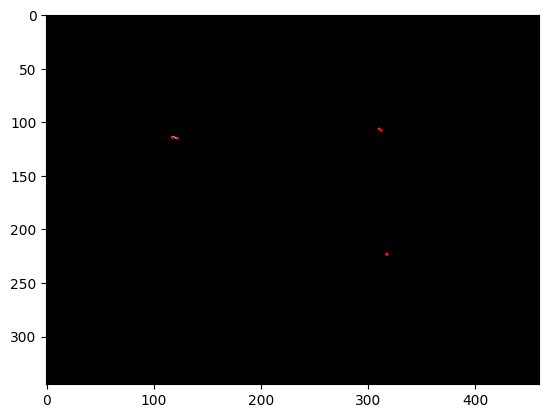

Endpoint (107, 312) reached
Endpoint [106 310] has been processed
Used Endpoints: {(107, 312), (106, 310)}
Endpoint [107 312] has already been used
Endpoint (115, 122) reached
Endpoint [114 117] has been processed
Used Endpoints: {(114, 117), (107, 312), (115, 122), (106, 310)}
Endpoint [115 122] has already been used
Endpoint (223, 318) reached
Endpoint [223 317] has been processed
Used Endpoints: {(114, 117), (115, 122), (107, 312), (223, 318), (223, 317), (106, 310)}
Endpoint [223 318] has already been used
3


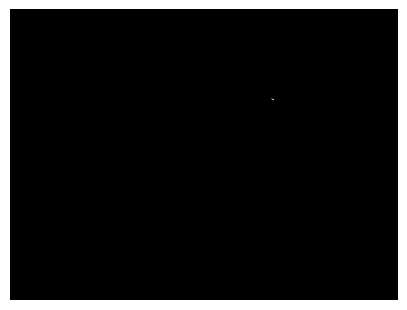

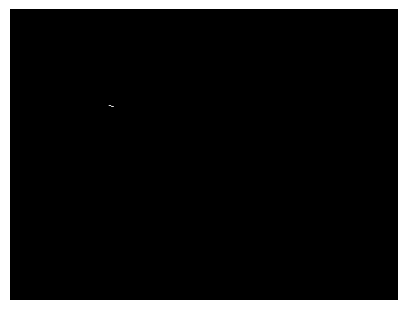

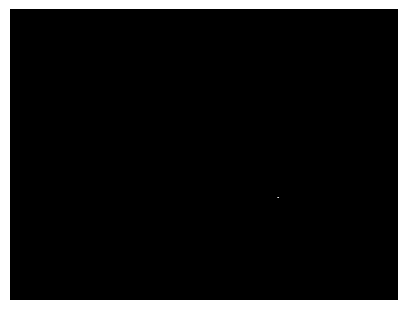

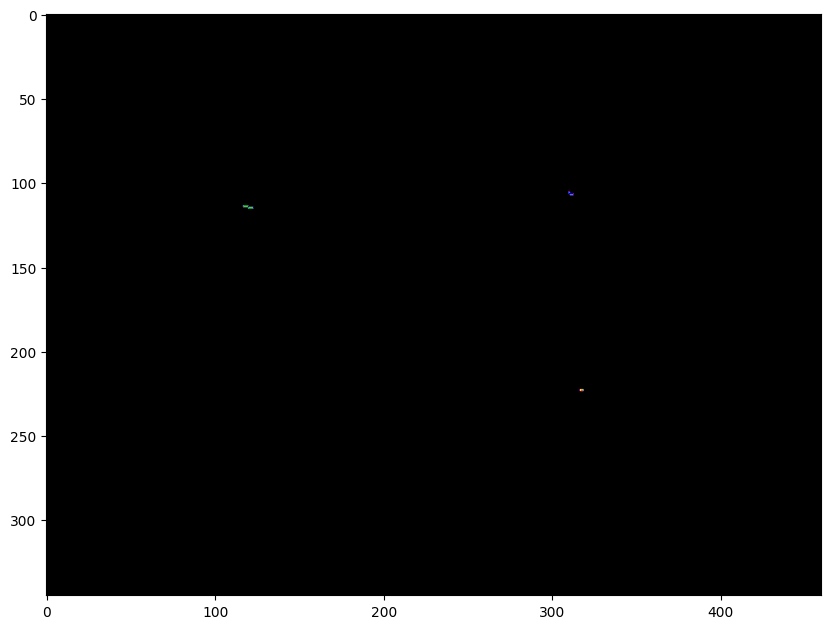

In [55]:
def get_connected_pixels(point, mask):
    neighbors = [
        (point[0] - 1, point[1] - 1), (point[0] - 1, point[1]), (point[0] - 1, point[1] + 1),
        (point[0], point[1] - 1),                             (point[0], point[1] + 1),
        (point[0] + 1, point[1] - 1), (point[0] + 1, point[1]), (point[0] + 1, point[1] + 1)
    ]
    return [p for p in neighbors if 0 <= p[0] < mask.shape[0] and 0 <= p[1] < mask.shape[1] and mask[p] == 1]

def direction(point1, point2):
    return (point2[0] - point1[0], point2[1] - point1[1])

def follow_root(mask, start_point, endpoints, used_endpoints):
    instance = np.zeros_like(mask)
    current_point = start_point
    direction_vector = (0, 0)
    visited_points = set()
    while True:
        instance[current_point[0], current_point[1]] = 1
        visited_points.add(tuple(current_point))
        possible_points = get_connected_pixels(current_point, mask)
        
        # Remove already visited points
        possible_points = [p for p in possible_points if tuple(p) not in visited_points]
        
        if not possible_points:
            break
        
        # Choose the direction closest to the current direction_vector
        if direction_vector != (0, 0):
            possible_points = sorted(possible_points, key=lambda p: np.dot(direction_vector, direction(current_point, p)), reverse=True)
        
        # Update current_point and direction_vector
        next_point = possible_points[0]
        direction_vector = direction(current_point, next_point)
        current_point = next_point
        
        # Stop if we reach another endpoint
        if tuple(current_point) in endpoints:
            print(f"Endpoint {current_point} reached")
            instance[current_point[0], current_point[1]] = 1
            used_endpoints.add(tuple(current_point))
            break
    
    return instance

instances = []
# Pop endpoint from list if it has already been used
endpoints = get_endpoints(filtered_masks[0])
print(f"Endpoints: {endpoints}")
used_endpoints = set()

# Plot the endpoints on the mask
fig, ax = plt.subplots()
ax.imshow(filtered_masks[0], cmap='gray')
for endpoint in endpoints:
    ax.plot(endpoint[1], endpoint[0], 'ro', markersize=1)
plt.show()

for endpoint in endpoints:
    if tuple(endpoint) in used_endpoints:
        print(f"Endpoint {endpoint} has already been used")
        continue
    instance = follow_root(filtered_masks[0], tuple(endpoint), set(map(tuple, endpoints)), used_endpoints)
    instances.append(instance)
    used_endpoints.add(tuple(endpoint))
    print(f"Endpoint {endpoint} has been processed")
    print(f"Used Endpoints: {used_endpoints}")
    # Follow the shoot from the endpoint, assume that the most probable continuation is the pixel in front or on the corners in the direction of the shoot
    # Get all the pixels connected to the point and get the one with the highest probability of being the continuation of the shoot
    # Check if new pixel is inside endpoints, if it is then stop following the shoot

print(len(instances))

# Plot each instance separately
for i, instance in enumerate(instances):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(instance, cmap='gray')
    ax.axis('off')
    plt.show()

# Create an empty image
combined = np.zeros_like(instances[0])

# Assign different pixel values to each instance
for i, instance in enumerate(instances):
    combined[instance > 0] = i + 1

# Plot the combined image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(combined, cmap='nipy_spectral')  # 'nipy_spectral' is a good colormap for distinguishing different colors
plt.show()

Number of labels in original: 8
Number of labels in skeleton: 3
Number of labels in original: 16
Number of labels in skeleton: 8
Number of labels in original: 26
Number of labels in skeleton: 11
Number of labels in original: 19
Number of labels in skeleton: 12
Number of labels in original: 19
Number of labels in skeleton: 12
Number of labels in original: 14
Number of labels in skeleton: 11
Number of labels in original: 13
Number of labels in skeleton: 8


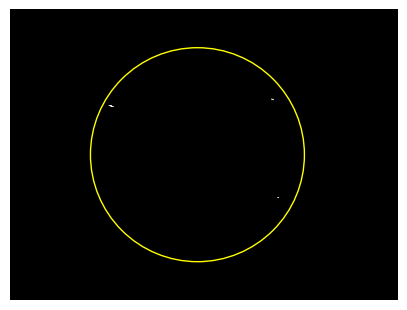

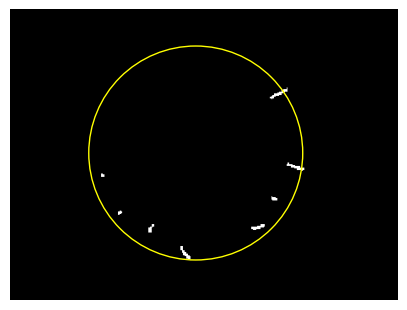

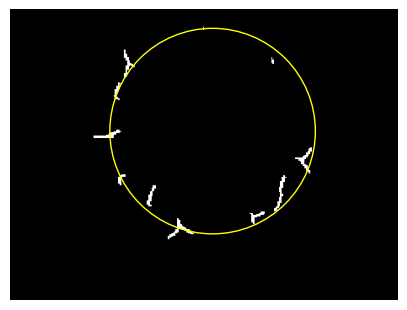

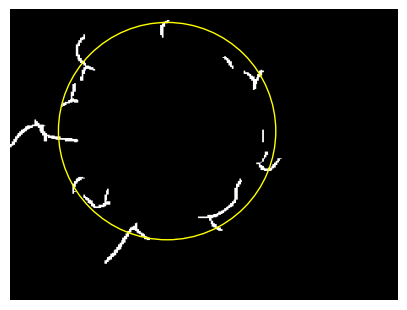

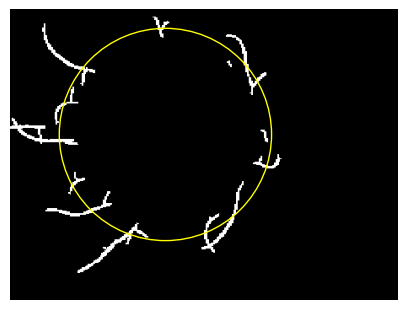

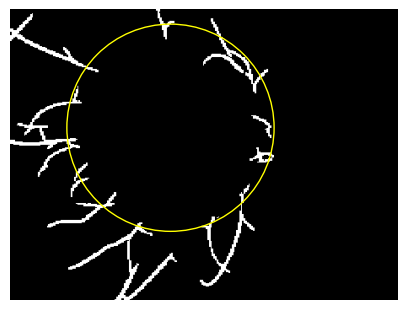

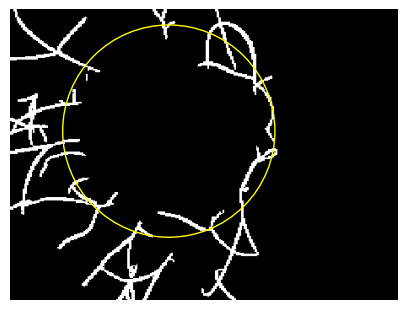

In [16]:
# Using predicted masks instead of skeletonised masks

updated_masks = []

for original, skeleton in zip(resized_predictions, filtered_masks):
    # Perform an "and" operation (logical and)
    labeled_original, num_labels_og = label(original, structure=s)
    labeled_skeleton, num_labels = label(skeleton, structure=s)

    print(f"Number of labels in original: {num_labels_og}")
    print(f"Number of labels in skeleton: {num_labels}")

    new_image = np.zeros_like(original).astype(np.uint8)

    for skeleton in range(1, num_labels + 1):
        # get the highlighted area
        highlighted = np.where(labeled_skeleton == skeleton, 1, 0)

        # get the label of the orifinal image that corresponds to the shape in the skeleton i.e. find the shoot in the original image that corresponds to its skeleton
        # i.e find the label in the original image that has the most overlap with the skeleton
        max_overlap = 0
        best_label = 0
        for og in range(1, num_labels_og + 1):
            overlap = np.sum(np.logical_and(np.where(labeled_original == og, 1, 0), highlighted))
            if overlap > max_overlap:
                max_overlap = overlap
                best_label = og

        new_image += np.where(labeled_original == best_label, 1, 0).astype(np.uint8)

    updated_masks.append(new_image)


for i, updated_mask in enumerate(updated_masks):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(updated_mask, cmap='gray')
    plt.axis('off')

    # Display the circle
    circle = plt.Circle(saved_circles[i][0], saved_circles[i][1], color='yellow', fill=False)
    ax.add_artist(circle)

    plt.plot()

### Step 4 (b): Identifying individual within pot

Processing image 0
Number of labels: 3
End points: [[106 310]
 [107 312]]
Angle: 324.16234704572173, Sector: 14
End points: [[114 117]
 [115 122]]
Angle: 208.9154243416267, Sector: 9
End points: [[223 317]
 [223 318]]
Angle: 27.979474388480146, Sector: 1
Processing image 1
Number of labels: 8
End points: [[ 93 328]
 [104 308]]
Angle: 323.13010235415595, Sector: 14
End points: [[183 329]
 [188 347]]
Angle: 6.801314823981575, Sector: 0
End points: [[195 108]
 [196 110]]
Angle: 167.41703750592308, Sector: 7
End points: [[222 310]
 [224 315]]
Angle: 29.614811646346425, Sector: 1
End points: [[241 131]
 [242 128]]
Angle: 141.95295746817393, Sector: 6
End points: [[255 169]
 [263 165]]
Angle: 120.59997869320895, Sector: 5
End points: [[256 299]
 [259 286]]
Angle: 47.42927332349997, Sector: 2
End points: [[281 203]
 [294 211]]
Angle: 94.1512852664217, Sector: 4
Processing image 2
Number of labels: 11
End points: [[ 21 229]
 [ 24 229]]
Angle: 264.7625239331875, Sector: 11
End points: [[ 49 135

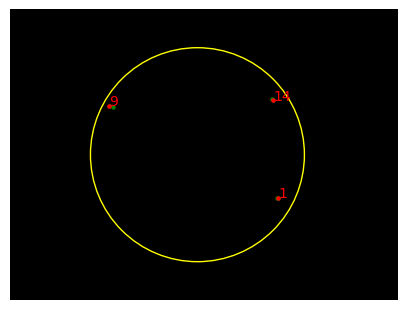

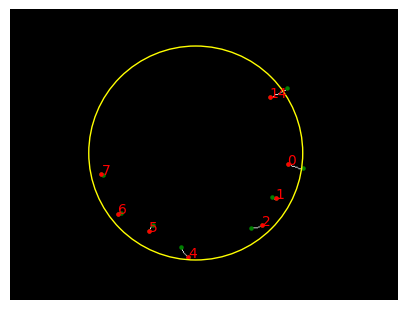

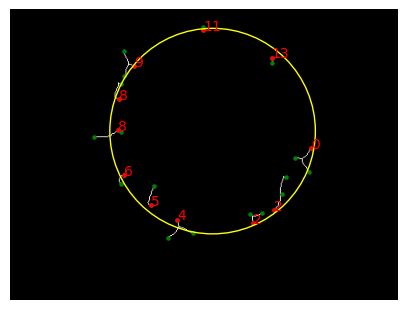

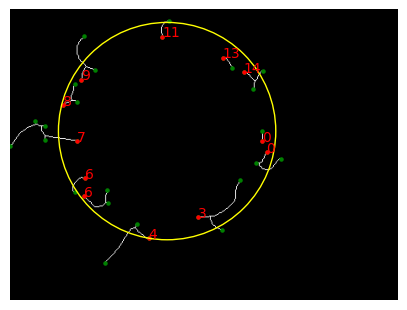

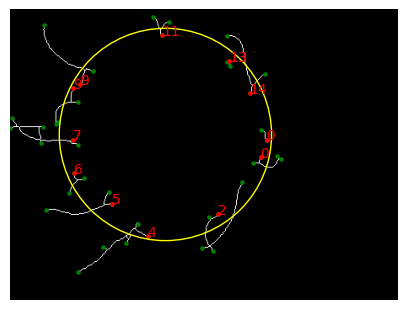

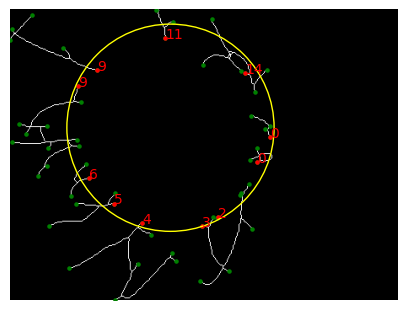

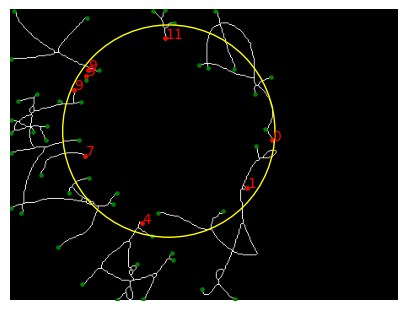

In [17]:
# For each img in the time series, break down the circle into 16 sectors and determine which shoot is in which segment

def get_sectors(endpoints: list, circle_coords: tuple, nb_sectors: int, ax) -> int:
    """
    Determine the segment of the circle that the shoot is from
    """

    # Get the circle
    (x, y), r = circle_coords

    # remove any endpoints outside of the circle
    endpoints = [point for point in endpoints if np.sqrt((point[1] - x)**2 + (point[0] - y)**2) <= r]
    
    # There are edge cases where they may be endpoints in several sctors the shoot tip and the shoot base, we assume that the shoot base is the one that is closest to the rim of the pot so order the endpoints by distance to the rim of the pot
    # sense of the radius - needs to be closer to the radius
    endpoints = sorted(endpoints, key=lambda point: np.sqrt((point[1] - x)**2 + (point[0] - y)**2), reverse=True)
    
    # plot the endpoints[0] in green
    ax.scatter(endpoints[0][1], endpoints[0][0], c='red', s=5)

    # determine sector of the circle that the shoot is in based in the endpoints[0]
    # Calculate the angle of the shoot tip
    angle = np.arctan2(endpoints[0][0] - y, endpoints[0][1] - x) * 180 / np.pi

    # Make sure the angle is positive
    if angle < 0:
        angle += 360

    # Calculate the sector
    sector = int(angle / (360 / nb_sectors))

    # annotate endpoint with the sector number
    ax.annotate(sector, (endpoints[0][1], endpoints[0][0]), color='red')

    print(f"Angle: {angle}, Sector: {sector}")

    return sector
    

# create a csv with 16 columns (one for each sector as sector is equivalent to an individual)
# each row will be a time point
# each cell will be the area of that sector with the shoot in it (ratio value)

tracking_total_length = np.zeros((len(filtered_masks), 16))
tracking_area_sector_ratio = np.zeros((len(filtered_masks), 16))


for i, filtered_mask in enumerate(filtered_masks):
    print(f"Processing image {i}")
    (x, y), r = saved_circles[i]

    sector_area = np.pi * r**2 / 16

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    labeled_skeletons, num_labels = label(filtered_masks[i], structure=s)
    labeled_original_post_filter, _ = label(updated_masks[i], structure=s)

    print(f"Number of labels: {num_labels}")

    for skeleton in range(1, num_labels + 1):
        highlighted = np.where(labeled_skeletons == skeleton, 1, 0)

        highlited_or = np.where(labeled_original_post_filter == skeleton, 1, 0)

        end_points = get_endpoints(highlighted)  # Careful they are returned as [[y, x]]
        print(f"End points: {end_points}")

        # plot the endpoints in green
        for point in end_points:
            ax.scatter(point[1], point[0], c='green', s=5)

        if len(end_points) != 0:
            sector = get_sectors(end_points, saved_circles[i], 16, ax)
            # in theory if there is a one to one relationship between the shoot and the sector this would be a = not a +=
            tracking_total_length[i, sector] += np.sum(highlighted)
            
            # TODO: To make it a ratio divide by the area of the sector
            tracking_area_sector_ratio[i, sector] += np.sum(highlited_or) / sector_area
            
        else:
            print("No endpoints found")
    
    ax.imshow(filtered_mask, cmap='gray')
    plt.axis('off')

    # Display the circle
    circle = plt.Circle((x, y), r, color='yellow', fill=False)
    ax.add_artist(circle)

    plt.plot()

## Step 5: Tracking development

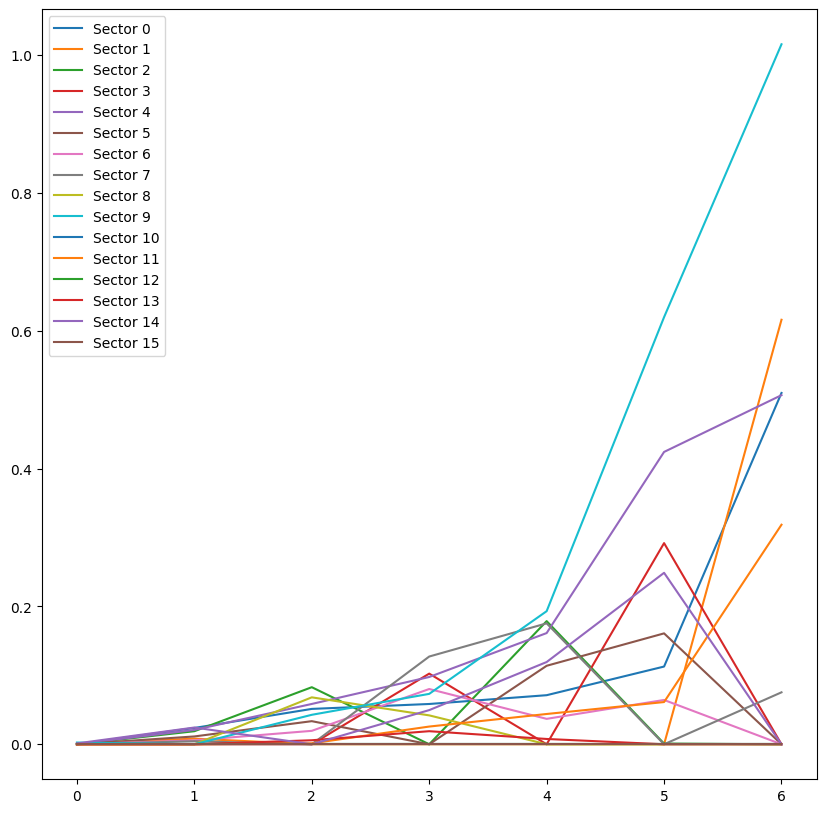

In [18]:
# TODO: at the moment we are using the area of the skeleton - we should be using the area of the actual shoot segmentation within that sector as it is a proxy for what we are aiming for - outcompeting the weeds

# plot tracking colour per sector scatter (x = time, y = value (highlited area), colour = sector)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for i in range(16):
    ax.plot(range(len(filtered_masks)), tracking_area_sector_ratio[:, i], label=f"Sector {i}")

plt.legend()